In [38]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from datetime import datetime, timezone, timedelta
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xmitgcm as xm
import time
import socket

# %matplotlib notebook

In [39]:
from datalakes import download_data_from_datalakes_dataset
from alplakes import parse_alplakes_3d_timeserie_from_directory, get_3d_profile_from_api, open_json, parse_json_3d_profile_to_df, parse_alplakes_1d_from_directory, parse_alplakes_json_3d_timeserie_to_df,parse_alplakes_json_profile_to_df
from utils import save_json
from mitgcm.utils_mitgcm import open_mitgcm_ds_from_config

# Comparison between MITgcm results, simstrat results (from Alplakes) and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
It imports local MITgcm simulation results.

In [40]:
lake_name = "Zurich"
sta_name = 'mythenquai_zurich'

model = 'test_zurich'

In [41]:
var_to_plot = 'THETA'

In [43]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']
xc_mitgcm_station

712

## Import MITgcm results

In [6]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('mitgcm/config.json', model)

## Import measure

In [7]:
#ds_to_plot['time']

In [44]:
start_date = pd.to_datetime(ds_to_plot['time'].values[0],utc=True).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(ds_to_plot['time'].values[-1],utc=True).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)
start_date

datetime.datetime(2024, 3, 6, 0, 59, 44, tzinfo=datetime.timezone.utc)

 ### Hydronaut or Delft3D

In [47]:
#xr_measure = xr.open_dataset(f'./data/datalakes/geneva_idronaut/2024.nc')
#xr_measure = xr.open_dataset(f'C:/Users/rasmusso/Documents/ZH/data/measurement kanton/zurich_profile_2024.xlsx')

date_plot_timeseries_str = '202406010000'
print(date_plot_timeseries_str)

json_folder = f"data/alplakes_3d/{sta_name}/timeseries_0m"

alplakes_timeseries = parse_alplakes_3d_timeserie_from_directory(json_folder)

alplakes_timeseries['time'] = pd.to_datetime(alplakes_timeseries['time'])
print(alplakes_timeseries)

202406010000
                         time  temperature
0   2024-03-01 00:00:00+00:00        6.992
1   2024-03-01 03:00:16+00:00        6.961
2   2024-03-01 06:00:00+00:00        6.951
3   2024-03-01 08:59:44+00:00        6.950
4   2024-03-01 12:00:00+00:00        6.983
..                        ...          ...
236 2024-06-30 12:00:00+00:00       21.097
237 2024-06-30 15:00:00+00:00       20.990
238 2024-06-30 18:00:00+00:00       20.920
239 2024-06-30 21:00:00+00:00       20.787
240 2024-07-01 00:00:00+00:00       20.665

[1470 rows x 2 columns]


### Measurements

In [54]:
measurement_file = r'data/alplakes_3d/mythenquai_zurich/measurements/mythenquai_data.csv' 
#use xlsx or csv instead of nc to read the measurements
#df = pd.read_excel(measurement_file,header=1, engine='openpyxl')
df = pd.read_csv(measurement_file)
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
adjusted_meas = df.loc[mask]
print(df.water_temperature)

0         6.5
1         6.5
2         6.5
3         6.5
4         6.5
         ... 
69942    14.4
69943    14.5
69944    14.6
69945    14.5
69946    14.5
Name: water_temperature, Length: 69947, dtype: float64


xr_measure = download_data_from_datalakes_dataset(667, start_date.replace(tzinfo=timezone.utc), end_date.replace(tzinfo=timezone.utc), "idronaut")

## Import simstrat alplakes 1d 

In [90]:
folder_path = '../simstrat_data'
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

## Plot timeseries temperature at depth "depth_simu"
#### dataklakes

depth_plot=-1 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if xr_measure is not None:
    meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    meas_selected.plot(label=f'Measure Idronaut', color='r')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

#plt.savefig(rf"output_plots\{lake_name}\geneva_1year_200m_{depth_plot}m.png")

### alplakes

Text(0.5, 1.0, 'Temperature mythenquai_zurich at depth 0m')

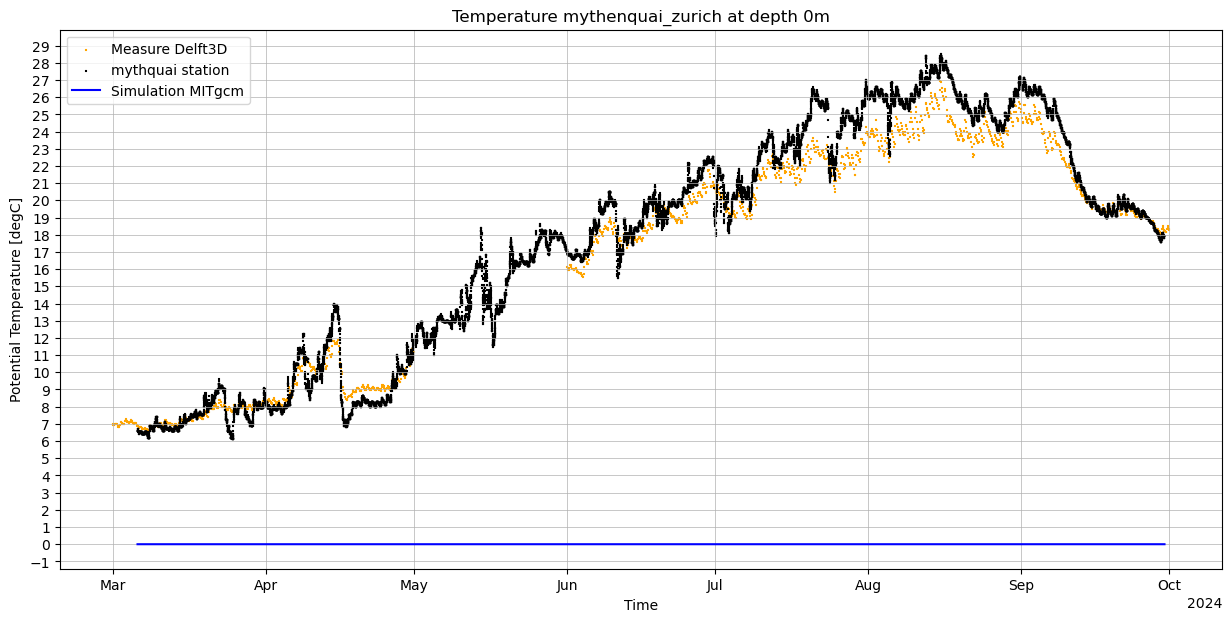

In [58]:
depth_plot=0 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if alplakes_timeseries is not None:
    #meas_selected = xr_measure['temperature']#.sel(depth=depth_plot, method='nearest') #.sel(time=slice(start_date,end_date))
    plt.scatter(alplakes_timeseries['time'],alplakes_timeseries['temperature'],label=f'Measure Delft3D', marker='+', s=3, c='orange')

#simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')
plt.scatter(adjusted_meas.timestamp,adjusted_meas.water_temperature, label=r'mythquai station', marker='+', s=3, c='k')

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest') #.sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

#plt.savefig(rf"timeseries_{sta_name}_{depth_plot}m.png")

# Profile

In [52]:
print(df.columns[1:].to_list())

with open(f"data/alplakes_3d_profile_{sta_name}/{date_plot_profil_str}.json", 'r') as file:
    alplakes_json = json.load(file)
alplakes_profile = parse_alplakes_json_profile_to_df(alplakes_json)
#alplakes_profile

['03.01.2024', '07.02.2024', '06.03.2024', '03.04.2024', '07.05.2024', '05.06.2024', '03.07.2024', '07.08.2024', '04.09.2024', '09.10.2024', '06.11.2024', '04.12.2024']


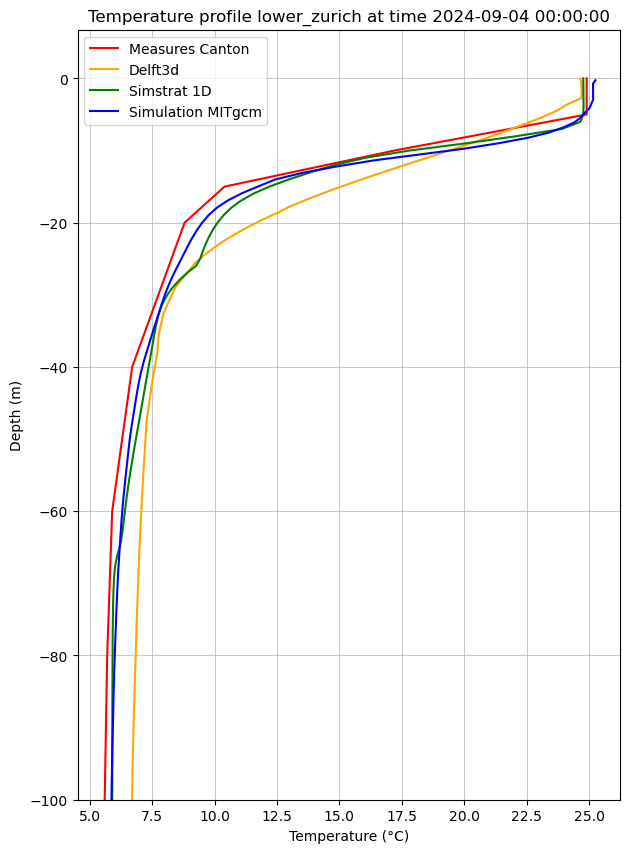

In [51]:
fig = plt.figure(figsize=(7, 10))

#meas_profile = xr_measure['temp'].sel(time=date_plot_profil, method='nearest')
#plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Measure Idronaut', color='r')

# plot the xlsx format, just change the DATE
plt.plot(df['04.09.2024'],-1*df.Depth, label=f'Measures Canton', color='r')

plt.plot(alplakes_profile.temperature,-1*alplakes_profile.depth, label=f'Delft3d', color='orange')
# Convert Simstrat depth to negative and plot
simstrat_depth_negative = -simstrat_data['depth'].values  # Convert to negative NumPy array
simstrat_temperature = simstrat_data['temperature'].sel(time=date_plot_profil, method='nearest')
plt.plot(simstrat_temperature.values, simstrat_depth_negative, label='Simstrat 1D', color='g')


profile_to_plot = ds_to_plot['THETA'].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest')
profile_to_plot.where(profile_to_plot != 0, np.nan).plot(y='Z', label='Simulation MITgcm', color='b')

plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.ylim(bottom=-100)
plt.xlabel('Temperature (°C)')
plt.legend()
plt.savefig(rf"{lake_name}_profile_{date_plot_profil.date()}_UTC.png")
plt.show()